<center> <img src="https://www.ufrn.br/resources/documentos/identidadevisual/brasao/brasao_flat.png" width="100" height="100"> </center>

---

## **TRABALHO - 3ª UNIDADE**

* Disciplina: Controle Digital (ELE0531)

* Docente: Aldayr Dantas de Araújo

* Discente: Douglas Wilian Lima Silva

---

### **Apresentação do Problema**


O projeto consiste em um sistema de controle visando a manutenção da temperatura de um sistema de misturador. O sistema é composto por dois recipientes em que através da referência de temperatura no recipiente de entrada $T_i$ (limitado pela borda azul) seja possível manter estável a temperatura no recipiente de saída $T_o$ conectados fisicamente.

A figura a seguir apresenta a estrutura do sistema proposto.

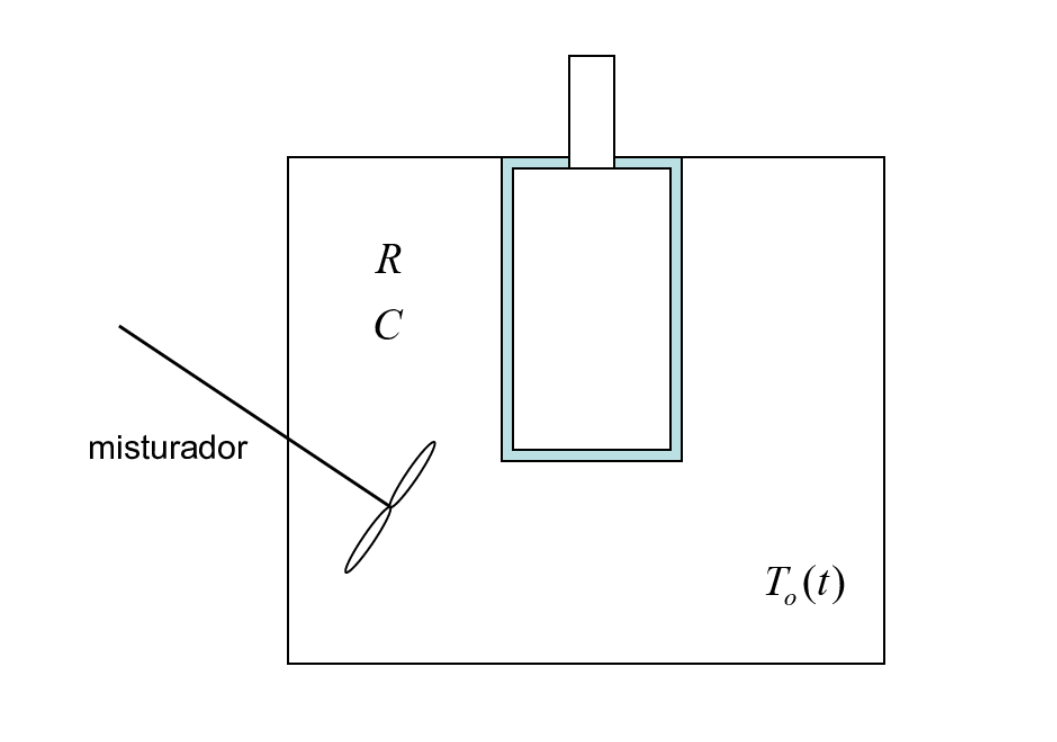

### **Modelagem Matemática da Planta**

Sabemos que a relação entre o calor transferido entre os recipientes é dada pela diferença de temperatura entre eles e o inverso da resistência térmica do meio. Com isso, definimos:

\begin{align*}
c(t) = \dfrac{1}{R}(T_i(t) - T_o(t))
\end{align*}

Logo, isolando a saída desejada, podemos obter:

\begin{align*}
T_i(t) = Rc(t) + T_o(t)
\end{align*}

Além disso, a temperatura do fluido presente no recipiente de saída se relaciona com o calor transferido através de sua capacidade térmica $C$, pela expressão:

\begin{align}
T_o(t) = \dfrac{1}{C}\int_0^{t}c(\tau)d\tau \implies \dot{T}_o(t) = \dfrac{1}{C}\times c(t)
\end{align}

Substituindo a equação obtida na expressão de saída, obtemos:

\begin{align}
T_i(t) = RC\dot{T_o}(t) + T_o(t)
\end{align}

Por fim, aplicando a Transformada de Laplace e isolando os termos, obtemos a seguinte expressão:

\begin{align}
T_i(s) = RCsT_o(s) + T_o(s) \implies T_o(s)[RCs + 1] = T_i(s)
\end{align}


\begin{align}
\dfrac{T_o(s)}{T_i(s)} = G_p(s) = \dfrac{1}{RCs + 1}
\end{align}

### **Análise do Sistema**

Considerando a resistência térmica do meio como $R = 5\times10^{-2}$ $K\cdot m/W$ e sua capacidade igual a $C=2$ $J/K$, obtemos a seguinte função de transferência que modela o sistema de primeira ordem.

\begin{align}
G_p(s) = \dfrac{1}{0,1s + 1}
\end{align}

Na forma mônica, temos:

\begin{align}
G_p(s) = \dfrac{10}{s + 10}
\end{align}

### **Características de Desempenho**



Queremos regular a temperatura de saída de acordo com a referência no valor de 10, com erro em regime nulo e sem oscilações. Para isso, é necessário em primeiro lugar verificar o comportamento da planta.

\begin{align}
e.r. = \lim_{s→0} \dfrac{10}{1+G_p(s)} \implies e.r. = \dfrac{10}{1 + 1} \implies e.r. = 5
\end{align}

In [1]:
!pip install control

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import control as ctl

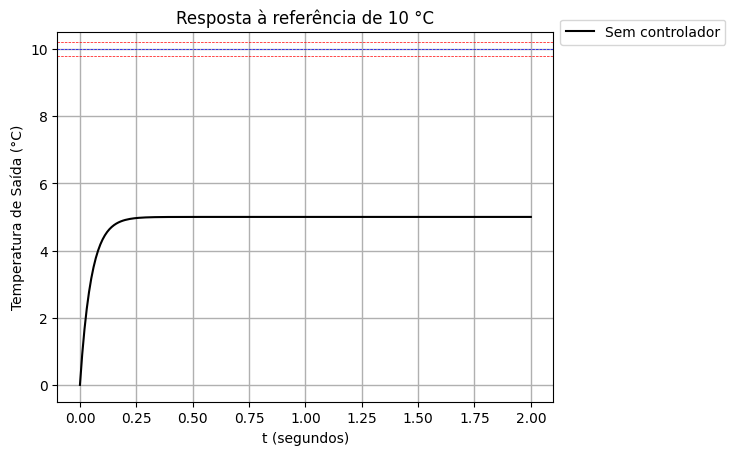

In [2]:
def plot_response(numGpd=[1], denGpd=[1, 1, 0], T_sim=20, h=0.01, REFERENCE=1):
  # Modelo da planta
  sysGpd = ctl.tf(numGpd, denGpd)

  # Modelo da realimentação unitária
  sysR = ctl.tf([1], [1])

  # Feedback sem o controlador
  sysFBs = ctl.feedback(sysGpd, sysR)

  tx = np.linspace(0, T_sim, int(T_sim/h))  # Pontos da simulação
  u = REFERENCE * np.ones_like(tx)  # Referencia constante

  t, h = ctl.forced_response(sysFBs, tx, u)

  ### Plotagem da resposta à entrada de tensão com a realimentação e sem o controlador
  plt.plot(t, h, color='black', linestyle = '-', label='Sem controlador')

  #### Eixos do gráfico
  plt.xlabel('t (segundos)')
  plt.ylabel('Temperatura de Saída (°C)')
  plt.title(f'Resposta à referência de {REFERENCE} °C')

  ESTAB = REFERENCE
  plt.axhline(y=ESTAB, color='blue', linestyle='--', lw=0.5)
  plt.axhline(y=ESTAB*1.02, color='red', linestyle='--', lw=0.5)
  plt.axhline(y=ESTAB*0.98, color='red', linestyle='--', lw=0.5)

  #### Plotagem do gráfico
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='center left')
  plt.grid(linewidth=1)
  plt.show()


numerator = [10]  # Numerador da função de transferência
denominator = [1, 10]  # Denominador da função de transferência

plot_response(numGpd = numerator, denGpd = denominator, T_sim = 2, h = 0.01, REFERENCE=10)

### **Implementação do Controlador**

Queremos melhorar o regime permanente, com isso, precisamos realizar a implementação de um controlador **Proporcional Integrativo (PI)**. Sua função de transferência é dada por:

\begin{align}
G_c(s) = \dfrac{K_c\left(s + \frac{1}{\tau_i}\right)}{s}
\end{align}

Para esta implementação, podemos utilizar a técnica de cancelamento de zeros com polos para simplificar a obtenção dos parâmetros. Com isso, definimos:

\begin{align}
s+\dfrac{1}{\tau_i} = s + 10 \implies \tau_i = 0,1
\end{align}

Com essa definição, o sistema em malha fechada será dado por:

\begin{align}
G_{MF} = \dfrac{10K_c}{s + 10K_c}
\end{align}

Assim, para um tempo de estabilização de 2 segundos, podemos obter a constante proporcional.

\begin{align}
Ts_{2\%} = \dfrac{4}{10K_c} \implies K_c = \dfrac{4}{10\cdot 2} \implies K_c = 0,2
\end{align}

\begin{align}
G_c(s) = \dfrac{0,2s + 2}{s}
\end{align}

### **Lugar das raízes**

Podemos também utilizar a biblioteca control para verificar o lugar geométrico das raízes da planta e após a implementação do controlador proposto.

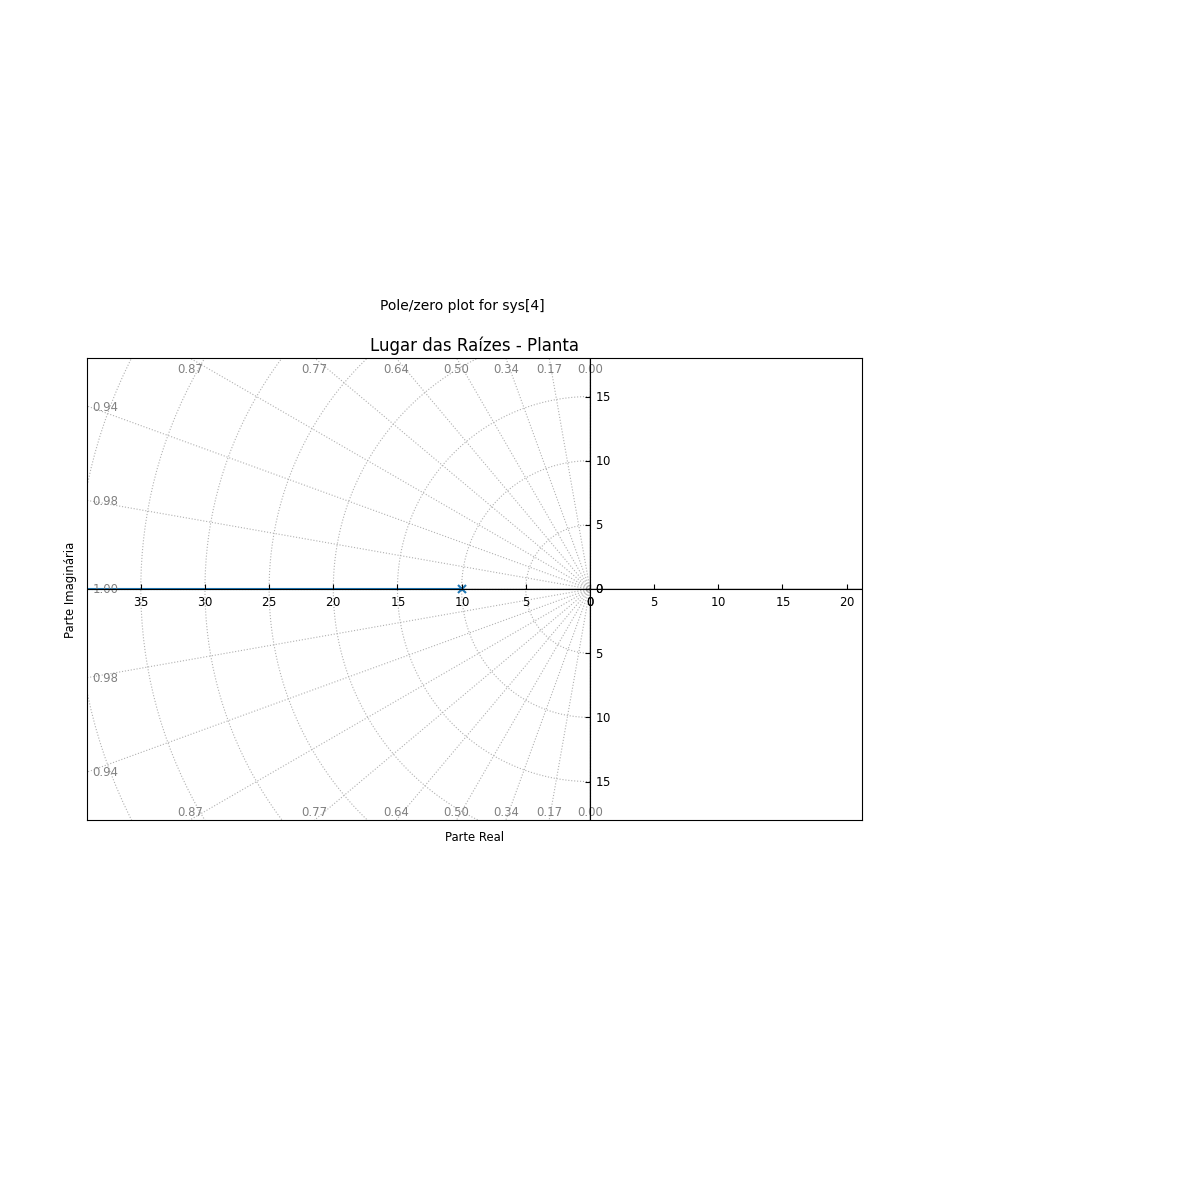

In [3]:
import control as ctrl
import matplotlib.pyplot as plt
Gs_num = [10]
Gs_den=[1, 10]

# Criar sistema de controle com a função de transferência em malha aberta
Gs_ctrl = ctrl.TransferFunction(Gs_num, Gs_den)

# Função de transferência em malha aberta com controlador
open_loop_system = Gs_ctrl

# Plotar o lugar das raízes
plt.figure(figsize=(10,6))
ctrl.root_locus(open_loop_system)
plt.title('Lugar das Raízes - Planta')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.grid(True)
plt.show()


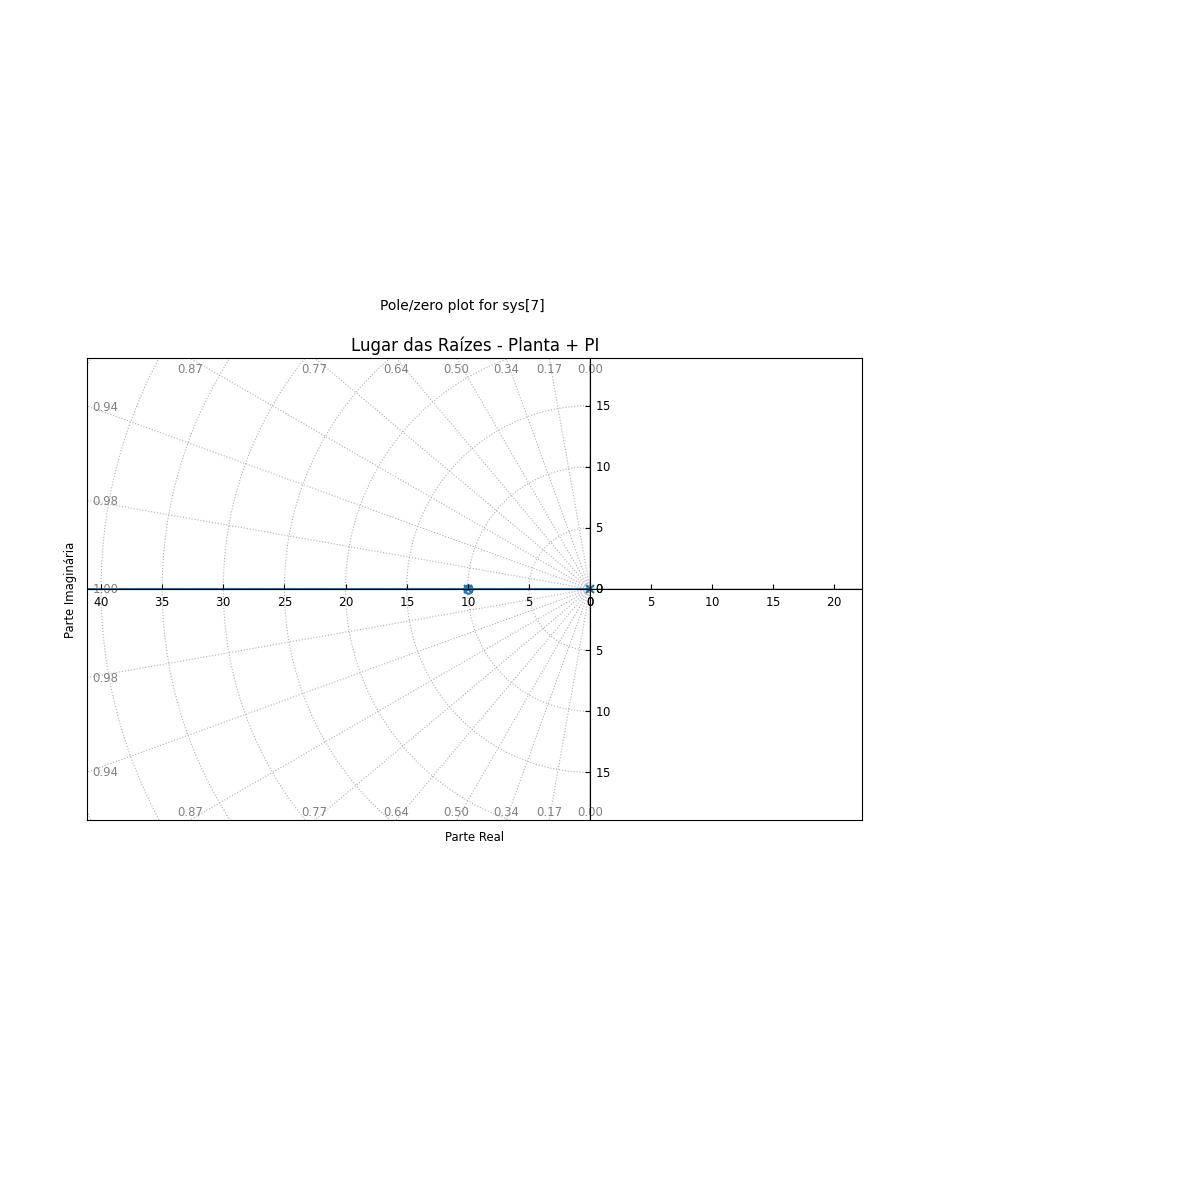

In [4]:
import control as ctrl
import matplotlib.pyplot as plt
Gs_num = [10]
Gs_den=[1, 10]

Gc_num = [0.2, 2]
Gc_den = [1,0]

Gps = ctrl.TransferFunction(Gs_num, Gs_den)
Gpc = ctrl.TransferFunction(Gc_num, Gc_den)

# Função de transferência em malha aberta com controlador
open_loop_system = Gpc*Gps

# Plotar o lugar das raízes
plt.figure(figsize=(10,6))
ctrl.root_locus(open_loop_system)
plt.title('Lugar das Raízes - Planta + PI')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.grid(True)
plt.show()


### **Discretização do Controlador**

Temos um controlador PI, assim, podemos utilizar a aproximação de Euler para transferi-lo para o domínio $z$. Logo:


Por Euler: $s = \dfrac{1-z^{-1}}{hz^{-1}}$

\begin{align}
G_c(z) = \dfrac{\frac{0,2-0,2z^{-1}}{hz^{-1}} + 2}{\frac{1-z^{-1}}{hz^{-1}}} \implies G_c(z) = \dfrac{0,2 + z^{-1}(2h-0,2)}{1-z^{-1}}
\end{align}

\begin{align}
\dfrac{U(z)}{E(z)} = \dfrac{0,2 + z^{-1}(2h-0,2)}{1-z^{-1}}
\end{align}

Aplicando $Z^{-1}\{.\}$:

\begin{align}
u(k) - u(k-1) = 0,2e(k) + (2h-0,2)e(k-1)
\end{align}




\begin{align}
u(k)= u(k-1) + 0,2e(k) + (2h-0,2)e(k-1)
\end{align}

Com essa definição, já podemos realizar a implementação do algoritmo de controle.

<ipython-input-5-af747c4f3df7>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  saida[j]=y[-1]


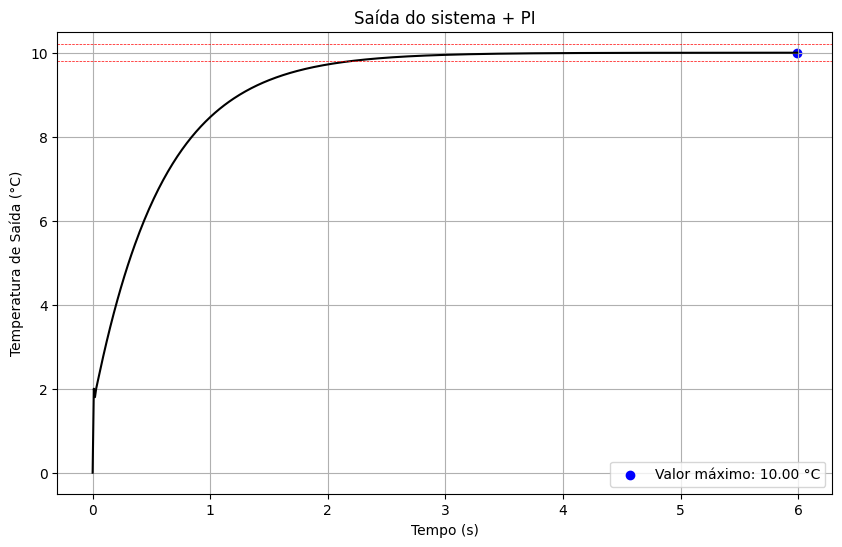

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

h = 0.01  # Amostragem < tau_min/10
tempo = 6  # Tempo de simulação
ref = 10  # Referencia

#Equação diferencial
def Gpa(y, t, u):
    dydt = 10*(u - y)
    return dydt

# --- Parâmetros ---

t = np.arange(0, tempo, h) #vetor de tempo
saida = np.zeros_like(t) #vetor da saída
u_out = np.zeros_like(t) #vetor do sinal de controle

e_ant=0
u_ant=0

# --- LOOP ---

for j in range(1, len(t)):

    e = ref - saida[j - 1] #ERRO R-Y
    u = u_ant + 0.2*e + (2*h-0.2)*e_ant #Sinal de controle calculado
    u_out[j] = u #Armazenamento do sinal de controle

    #Resolução da EDO usando ODEINT
    y0 = saida[j-1]
    y = odeint(Gpa, y0, t, args=(u,))
    saida[j]=y[-1]

    #Atualização dos parâmetros
    e_ant = e
    u_ant = u

#--- GRÁFICOS ---
plt.figure(figsize=(10, 6))
plt.plot(t, saida, color='black')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura de Saída (°C)')
plt.title('Saída do sistema + PI')

## Valor máximo
indice_min = np.argmax(saida)
x_min = t[indice_min]
y_min = saida[indice_min]

# Destaque do ponto máximo
plt.scatter(x_min, y_min, color='blue',
            label=f'Valor máximo: {y_min:.2f} °C')


#### Definir o valor de To de estabilização Ts2%
ESTAB_MAX = 0.98*ref
ESTAB_MIN = 1.02*ref
ESTAB = ref
plt.axhline(y=ESTAB_MIN, color='red', linestyle='--', lw=0.5)
plt.axhline(y=ESTAB_MAX, color='red', linestyle='--', lw=0.5)

plt.legend()
plt.grid(True)
plt.show()

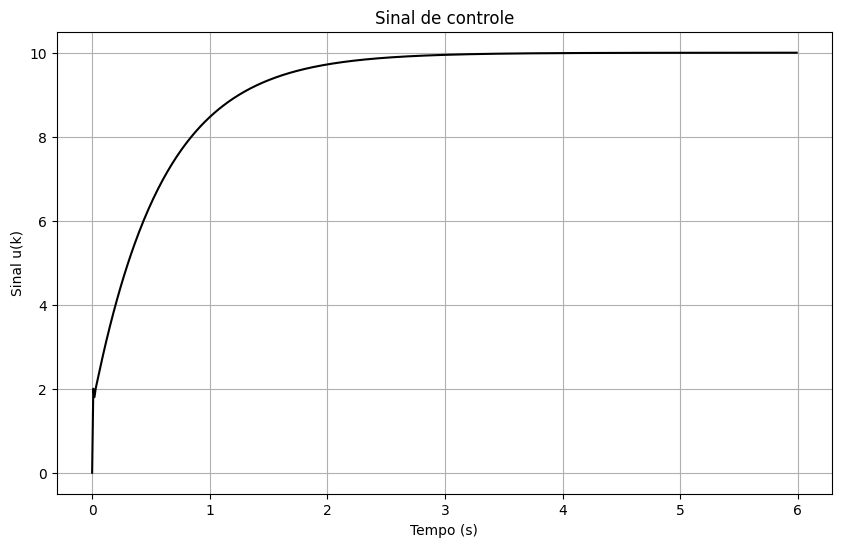

In [6]:
#--- GRÁFICOS ---
plt.figure(figsize=(10, 6))
plt.plot(t, u_out, color='black')
plt.xlabel('Tempo (s)')
plt.ylabel('Sinal u(k)')
plt.title('Sinal de controle')
plt.grid(True)
plt.show()